# Discrete Truncated Wigner Approximation in Fermionic Systems

We start with $m$ spinless fermions localized in $N$ lattice sites in the
single band tight-binding limit. The occupied sites are labelled $m_i$ and are
part of the set $\mathcal{M}$. Thus, the initial state is


\begin{equation}
|\Psi\rangle = \prod_{m_i\in\mathcal{M}}c^\dagger_{m_i}|0\rangle.
\end{equation}


We're interested in the Truncated Wigner dynamics of a generic Hamiltonian of the type

\begin{equation}
H = H_K + H_S + H_{SYK}
\end{equation}

where $H_K$ is the kinetic energy, $H_S$ is the static pair interaction term. Thus,

\begin{equation}
H_K  = -\frac{1}{2} \sum_{ij}J_{ij}\left(c^\dagger_ic^{\;}_j + \rm{ h.c. }\right) \\
H_S = \frac{1}{2} \sum_{ij}{\left(\Delta_{ij}c^\dagger_ic^{\dagger}_j + \rm{ h.c. }\right)}.
\end{equation}

Where the matrix $\Delta$ is anti-hermitian, and, by default, $J_{ij} = \delta_{i,j+1} + \delta_{i, j-1}$. Finally, the $4-$fermion scattering
Hamiltonian

\begin{equation}
H_{SYK} = \sum_{ijkl} V_{ijkl}\; c^\dagger_i c^\dagger_j c^\;_k c^\;_l.
\end{equation}

Note that, in order for $H_{SYK}$ to be Hermitian, we'll require the following
contsraints on the tensor $V_{ijkl}$

\begin{eqnarray}
V_{ijkl} &= -V_{ijlk} =& -V_{jikl} \nonumber \\
&V_{ijkl} = V^\ast_{klij}&.\nonumber
\end{eqnarray}


## Exact Dynamics in Qubit basis

The exact quantum dynamics of the Hamiltonian above can be readily simulated using the
OpenFermion package. The operator expression for the Hamiltonian is symbolically parsed
into a sparse matrix $H$ in the occupation number representation, which consists of the
$2^N$ Fock states given by $|n_0, n_1, \dots n_{N-1}\rangle$, where $n_i = 0,1$. Then, the initial state is formulated in the same representation and parsed into a vector $|\psi_0\rangle$. Then, the Schrodinger equation, $\partial_t\;|\psi(t)\rangle = -i\;H|\psi(t)\rangle$, is solved numerically using the Odeintw module with the initial condition $|\psi(0)\rangle = |\psi_0\rangle$. Finally, the following observables are computed from expectation values.

\begin{eqnarray}
n_x &=& c^\dagger_x c_x \nonumber\\
C(x,y) &=& \frac{1}{N^2}\sum_{x'y'}\langle c^\dagger_{x+x'}c^\dagger_{x'}c_{y'}c_{y+y'} \rangle.\nonumber\\
       &=& \sum_{pqrs} V^{xy}_{pqrs}\langle c^\dagger_pc^\dagger_qc^\;_rc^\;_s\rangle.
\end{eqnarray}

Here, $V^{xy}_{pqrs} = (N)^{-2}\delta_{|p-q|,x}\delta_{|r-s|,y}$, and the sums are cyclic over the lattice, *i.e* during the sum,  $x+x', y+y'$ are
counted from $x,y$ respectively to $N-1$, then cycled back to $0$ and strided to
$x-1, y-1$ respectively. Also, while evaluating the $4-$fermion correlation,
we choose $x=1, y=m$ for simplicity, so we actually calculate

\begin{equation}
C_m = \frac{1}{N^2}\sum_{x'y'}\langle c^\dagger_{1+x'}c^\dagger_{x'}c_{y'}c_{m+y'} \rangle.
\end{equation}

In [59]:
import numpy as np
from odeintw import odeintw
from openfermion.ops import FermionOperator, QuadraticHamiltonian, InteractionOperator
from openfermion.transforms import get_sparse_operator
from openfermion.utils import jw_configuration_state, number_operator
        
def evolve_fermion_exact(times, site, xy, args):
    (J, D, V, params) = args
    lsize = params["lattice_size"]    
    occupied_sites = params["occ_sites"]  

    if site is not None:
        #Operators in the Pauli spin basis. These are needed explicitly bcoz openfermion does not handle number operators properly
        c_dag = np.array([[0.,0.],[1.,0.]]) #c_dag = sigma_minus
        c = c_dag.T
        number_op = c_dag.dot(c) #This is c^\dagger_i c_i = sigma^-\sigma^+ in spin basis
        #Where to profile number of particles with number operator (construct directly in Pauli spin basis)
        n_site = number_op if site==0 else np.eye(2)
        for i in range(1, lsize):
            site_op = number_op if i==site else np.eye(2)
            n_site = np.kron(n_site, site_op)   

    if xy is not None:
        #Where to profile 4-fermion term (construct in second quantization and render into Pauli basis)
        (x,y) = (1, xy)
        Dx = (np.diagflat(np.ones(lsize-x),k=-x) + np.diagflat(np.ones(x),k=(lsize-x)))/lsize
        Dy = (np.diagflat(np.ones(lsize-y),k=y) + np.diagflat(np.ones(y),k=-(lsize-y)))/lsize        
        Cxy_op = InteractionOperator(0.0, np.zeros((lsize,lsize)),np.tensordot(Dx,Dy,axes=0))
        # Get scipy.sparse.csc representation and densify it to get the matrix for the operator and convert from numpy matrix to ndarray                
        Cxy = np.asarray(get_sparse_operator(Cxy_op).todense())
        
    #Build Kinetic + Pair Hamiltonian + SYK
    KE = np.zeros((lsize, lsize)) if J is None else J
    SC = np.zeros((lsize, lsize)) if D is None else D
    SYK = np.zeros((lsize, lsize, lsize, lsize)) if V is None else V
    H_op = QuadraticHamiltonian(-KE, SC) + InteractionOperator(0.0, np.zeros_like(KE), SYK)
    
    
    # Get scipy.sparse.csc representation and densify it to get the matrix for the operator and convert from numpy matrix to ndarray                
    H = np.asarray(get_sparse_operator(H_op).todense()) 

    #initially occupied states
    state_occ = jw_configuration_state(occupied_sites, lsize).flatten()
    psi_init = (state_occ + (1j) * np.zeros(2**lsize)) # This is stupid but apparently necessary
    psi_t = odeintw(lambda psi, t, H:np.dot((-1j) * H, psi), psi_init, times, args=(H,), Dfun=None)

    #Just calculate expetation values now
    n_site_av = np.einsum("ij,jk,ik->i", psi_t.conjugate(), n_site, psi_t) if site is not None else None
    cxy_av = -np.einsum("ij,jk,ik->i", psi_t.conjugate(), Cxy, psi_t) if xy is not None else None
    
    return n_site_av, cxy_av

print("Exact Dynamics defined and set")

Exact Dynamics defined and set


## Truncated Wigner Dynamics

To obtain the Truncated Wigner Dynamics, The Hamiltonian is re-written with the two operators

\begin{eqnarray}
\hat{\rho}_{\alpha\beta} &=& c^\dagger_\alpha c_\beta - \frac{1}{2}\delta_{\alpha\beta}\\
\hat{\tau}_{\alpha\beta} &=& c_\alpha c_\beta, \\
\end{eqnarray}

and the equivalent classical Hamiltonian obtained via the map $H\rightarrow H^{cl}$ with the following substitutions on $H$.

\begin{eqnarray}
&\frac{1}{2}\left(\hat{c}^\dagger_\alpha\hat{c}_\beta- \hat{c}_\beta
\hat{c}^\dagger_\alpha \right)& &\rightarrow& \rho_{\alpha\beta}\\
&\hat{c}_\alpha\hat{c}_\beta& &\rightarrow& \tau_{\alpha\beta}\\
&\hat{c}^\dagger_\alpha\hat{c}^\dagger_\beta& &\rightarrow& -\tau^\ast_{\alpha\beta}.
\end{eqnarray}

Now, the initial conditions for the $N \times N$ matrices $\rho$ and $\tau$ are chosen to
be Gaussian random numbers with mean and variance given by their exact initial
conditions, *i.e.*

\begin{equation}
P(\rho_{\alpha\beta}) = \begin{cases}
\sqrt{\frac{2}{\pi}} e^{-2(\rho_{\alpha\beta}-\frac{1}{2})^2}\delta_{\alpha\beta} & \mbox{ if } \alpha, \beta \in \mathcal{M}\\
-\frac{1}{2}\delta_{\alpha\beta} & \mbox{ otherwise },
\end{cases}
\end{equation}

and the initial $\tau_{\alpha\beta}=0$ due to the fact that the initial state is uncorrelated. Note that, for technical reasons, we have to choose the initial $\rho_{\alpha\beta}$ to be complex. If that is the case, then the average and variance of $\rho_{\alpha\alpha} = {\rho}^R_{\alpha\alpha} + i {\rho}^I_{\alpha\alpha}$ have to remain unaffected. Since

\begin{eqnarray}
\bar{\rho}_{\alpha\alpha} &=& \bar{\rho}^R_{\alpha\alpha} + \bar{\rho}^I_{\alpha\alpha} = \frac{1}{2} \\
\sigma^2\left[{\rho}_{\alpha\alpha} \right] &=& \sigma^2\left[{\rho}^R_{\alpha\alpha} \right] + \sigma^2\left[{\rho}^I_{\alpha\alpha} \right] + 2i \left(\overline{{\rho}^R_{\alpha\alpha}{\rho}^I_{\alpha\alpha}}-\bar{\rho}^R_{\alpha\alpha}\;\bar{\rho}^I_{\alpha\alpha}\right) = \frac{1}{4}
\end{eqnarray}
Thus, the average of the real part is $1/2$, the average of the imaginary part is $0$, the standard deviation of the real and imaginary parts (which are otherwise uncorrelated) are $1\mathbin{/}2\sqrt{2}$ 

The classical Hamiltonian for DTWA dynamics is 

\begin{multline}
H^{cl} = -\frac{1}{2}\sum_{ij}J_{ij}\left(\rho_{ij} + \rho_{ji}\right) +
\frac{1}{2}\sum_{ij} \Delta_{ij}\left(\tau_{ij} + \tau^\dagger_{ij}\right) \\
 +\sum_{i j k l} V_{i j k l}\left(\tau^\dagger_{ij} \tau_{k l}+\rho_{j k} \delta_{i l}+\rho_{i l} \delta_{k j}\right)
\end{multline}

The TWA dynamics can be written in terms of the classical phase space variables in $N \times N$ matrices $\rho$ and $\tau$, given by the dynamical equations of the matrix elements.

\begin{eqnarray}
\frac{\mathrm{d}\rho_{\alpha\beta}}{\mathrm{d}t} &=& \left\{\rho_{\alpha\beta}, H^{cl}\right\}_{fP}\\
\frac{\mathrm{d}\tau_{\alpha\beta}}{\mathrm{d}t} &=& \left\{\tau_{\alpha\beta}, H^{cl}\right\}_{fP},
\end{eqnarray}

yielding

\begin{eqnarray}
\frac{\mathrm{d}\rho}{\mathrm{d}t} &=& {i}\left[ \rho , J \right]
+ i \left(\Delta\tau^T+\tau^\ast\Delta\right) \nonumber\\
& & + 2i\big\{\left(\tau^\ast\otimes\tau\right)^T\vdots V^\ast + \left(V^\ast:\tau^\dagger\right)\tau^T + \bar{V}^\ast\cdot\rho - \rho^\dagger\cdot\bar{V}  \big\}\\
\frac{\mathrm{d}\tau}{\mathrm{d}t} &=& {i}\bigg\{J\tau - \left(J\tau\right)^T\bigg\}
+ i \left(\Delta\rho +\rho^T\Delta\right) \nonumber \\
& & + 2i\big\{\tau^T\cdot \bar{V}^\ast - \left(\rho^T\otimes\tau\right)^T\vdots\bar{V}^\ast - \bar{V}\cdot\tau - \left(V:\tau\right)\rho \big\}
\end{eqnarray}

Note that here,

* $A^T$ means a single permutation of the summing indices in tensor $A$,

* $\bar{V}$ a contracted sum of the middle two indices of $V$,

* $\otimes$ means outer tensor product, and,

* $A\; (\cdot, :, \vdots)B$ mean contraction of the last (one, two, three) indices of
$A$ and first (one, two, three) indices of $B$.

Using Einstein's summation convention, the equations can be re-written as

\begin{eqnarray}
\frac{\mathrm{d}}{\mathrm{d}t}\rho_{\alpha\beta} &=&
i\left(\rho_{\alpha i}J_{i\beta} - J_{\alpha i}\rho_{i\beta}\right) +
i \left(\Delta_{\alpha i}\tau^T_{i\beta} + \tau^\ast_{\alpha i}\Delta_{i\beta}\right)\nonumber\\
 & & -2i  V_{i j k l} \delta_{\alpha l}\left(\tau_{j i}^\ast \tau_{\beta k}+\delta_{i k} \rho_{j \beta}\right) + 2i  V^\ast_{i j k l} \delta_{\beta l}\left(\tau_{j i} \tau^\ast_{\alpha k}+\delta_{i k} \rho^\ast_{j \alpha}\right)\\
\frac{\mathrm{d}}{\mathrm{d}t}\tau_{\alpha\beta} &=& i \left(J_{\alpha i}\tau_{i\beta} -
\tau_{i\alpha}J_{i\beta} \right) + i \left(\Delta_{\alpha i}\rho_{i\beta}
+ \rho_{i\alpha}\Delta_{i\beta}\right) \nonumber\\
& & - 2i V_{i j k l} \delta_{\alpha j}\left(\delta_{i l} \tau_{k \beta}-\tau_{k l} \rho_{i \beta}\right) + 2i V_{i j k l} \delta_{\beta j}\left(\delta_{i l} \tau_{k \alpha}-\tau_{k l} \rho_{i \alpha}\right)
\end{eqnarray}

The initial conditions for $\rho$, $\tau$ are set to be Gaussian random numbers with
mean and variance set to the quantum mean and variance of the initial state as
described above. The results below are for $N = 10$ and
$\mathcal{M} = \left[0,2,4,6,8\right]$ (half-filled in position). The number of particles
at a site $i$ is computed from the mapping
$n_i = c^\dagger_i c^\;_i \rightarrow \rho_{ii} + 1/2$ and averaged over random
realizations. The onset of ODLRO can be seen in coordinate space by looking at the order
parameter as obtained from the $4$-fermion term

\begin{equation}
C(x,y) = \frac{1}{N^2}\sum_{x'y'}\langle c^\dagger_{x+x'}c^\dagger_{x'}c_{y'}c_{y+y'} \rangle.
\end{equation}

Let us simplify by choosing $x=1$. Then $C_m\equiv C(1, m)$ can be obtained from TWA
dynamics by the mapping

\begin{equation}
C_m\rightarrow -\frac{1}{N^2}\big(\rm{Tr}_{1-} + \rm{Tr}_{(N-1)+}\big)\left[\tau^\ast\right]\times\big(\rm{Tr}_{y-} + \rm{Tr}_{(N-y)+}\big)\left[\tau^T\right],
\end{equation}

where $\rm{Tr}_{k\pm}$ is the trace along the ${\pm k}^{th}$ diagonal of a matrix.
An alternative approach is to rewrite the $4$-fermion term as

\begin{eqnarray}
C(x,y) &=& \frac{1}{N^2}\sum_{x'y'}\langle c^\dagger_{x+x'}\left(\delta_{x'y'}- c_{y'}c^\dagger_{x'}\right)c_{y+y'} \rangle\nonumber \\
&=& \frac{1}{N^2}\sum_{x'y'}\bigg\{\langle c^\dagger_{x+x'}c_{y+y'} \rangle\delta_{x'y'} - \langle c^\dagger_{x+x'}c_{y'}c^\dagger_{x'}c_{y+y'} \rangle\bigg\}.
\end{eqnarray}

This can be obtained from TWA dynamics by the mapping

\begin{multline}
C(x,y)\rightarrow \frac{1}{N^2}\sum_{x'y'}\bigg\{\delta_{x'y'}\left(\rho_{x+x'\; y+y'} +
\frac{1}{2}\delta_{x+x'\; y+y'}\right) \\
- \left(\rho_{x+x'\; y'}+\frac{1}{2}\delta_{x+x'\; y'}\right)\left(\rho_{x'\; y+y'}+\frac{1}{2}\delta_{x'\; y+y'}\right)\bigg\}.
\end{multline}

Now, defining $C_m\equiv C(1, m)$, we have the TWA map

\begin{multline}
C_m \rightarrow \frac{\delta_{1m}}{N} + \frac{1}{N^2}\bigg\{\rm{Tr}_{(N-m+1)-}
\left[\rho \right] -\rm{Tr}_{(N-m-1)-}\left[\rho \right] \\
-\rm{Tr}_{(m+1)+}\left[\rho\right] - \rm{Tr}\left[\rho_1\rho^T_m\right]\bigg\},
\end{multline}

where $\rho_k$ is the matrix generated when each row of $\rho$ is rolled by $k$ indices.
Note that this expression includes some tricky finite size effects. In the thermodynamic
limit, when $N\rightarrow\infty$, all the single trace terms like
$\rm{Tr}_j[\rho]\sim N$, so the TWA map simplifies to

\begin{equation}
C_m \xrightarrow{N\rightarrow\infty} -\frac{1}{N^2} \rm{Tr}\left[\rho_1\rho^T_m\right].
\end{equation}

We elect to use the latter formula, as the finite size effects of the DTWA are spurious and have nothing to do with finite-size effects in the exact dynamics. Since the two approaches are formally equivalent, we choose an arithmetic mean of the two formulae. So, finally

\begin{multline}
C_m \xrightarrow{N\rightarrow\infty}
-\frac{1}{2N^2}\bigg\{ \rm{Tr}\left[\rho_1\rho^T_m\right] \\
+ \big(\rm{Tr}_{1-} + \rm{Tr}_{(N-1)+}\big)\left[\tau^\ast\right]\times\big(\rm{Tr}_{y-} + \rm{Tr}_{(N-y)+}\big)\left[\tau^T\right]\bigg\}
\end{multline}

The code cell below defines the Truncated Wigner Dynamics for the generalized spinless fermionic model.

In [73]:
import numpy as np

def get_rhomat_spinless(psi, lsize):
    N = lsize
    rho = psi[0:N**2].reshape((N,N))
    return rho

def get_taumat_spinless(psi, lsize):
    N = lsize
    size = 2 * N**2 
    halfsize = int(size/2)
    tau = psi[halfsize:].reshape((N,N))
    return tau

def diffmat(A,B):
    return A[:,np.newaxis] - B

def Dmat(q, n):
    diff = diffmat(np.arange(n), np.arange(n))
    return np.exp((1j) * q * diff)

def four_fermion(rho, tau,m):
    rows, cols = rho.shape
    
    #Exact in the thermodynamic limit
    cm_rho =  np.trace(np.dot( np.roll(rho,1,axis=0) , np.roll(rho,m,axis=0).T ))/(rows * cols)
    #Finite size effects
    #cm_rho += (1.0 if m == 1 else 0.0)/(2 * rows)
    #cm_rho += (np.trace(rho,offset =  - (cols - m + 1)) -\
    #            np.trace(rho,offset =  - (cols - m - 1)) -\
    #                    np.trace(rho,offset =  m + 1))/(rows * cols)
    
    cm_tau = np.trace(tau.conjugate(), offset=-1) + np.trace(tau.conjugate(), offset=rows-1)/rows
    cm_tau *= np.trace(tau.conjugate(), offset=-m) + np.trace(tau.conjugate(), offset=cols-m)/cols
    
    return (cm_rho + cm_tau)/2.0

# Define the right-hand-side of the TWA differential equation.
#CHECK THE SYK PART!!!
def dtwa(psi, t, J, D,V, args):
    rho = get_rhomat_spinless(psi, args["lattice_size"])
    tau = get_taumat_spinless(psi, args["lattice_size"])

    drhodt = np.zeros_like(rho)
    #J term
    if J is not None:
        drhodt +=  (1j) *  (np.dot(rho, J)  - np.dot(J, rho))
    #D term
    if D is not None:
        drhodt +=  (1j) * (D.dot(tau.T) + tau.conjugate().dot(D))
    #SYK (V) term
    if V is not None:
        mat = np.einsum("ijka,ji,bk->ab", V, tau.conjugate(), tau, optimize=True) + np.einsum("kjka,jb->ab",V,rho, optimize=True)
        drhodt += (-2j) * mat + (2j) * mat.conjugate().T

    dtaudt = np.zeros_like(tau)
    # J term
    if J is not None:
        Jtau = np.dot(J, tau)
        dtaudt +=  (1j) * (Jtau - Jtau.T)

    #D term
    if D is not None:
        dtaudt += (1j) * (D.dot(rho) + rho.T.dot(D))
    #SYK (V) terms
    if V is not None:
        mat = np.einsum("lakl,kb->ab",V,tau, optimize=True) - np.einsum("iakl,kl,ib->ab",V, tau, rho, optimize=True)
        dtaudt += (-2j) * mat + (2j) * mat.T

    return np.concatenate((drhodt.flatten(), dtaudt.flatten()))


def evolve_dtwa_pos(seed, times, site, xy, niter_loc, args):
    (J, D, V, params) = args
    lsize = params["lattice_size"]
    occupied_sites = params["occ_sites"]
    np.random.seed(seed)
    #Initial conditions
    rhomat = np.zeros((nsites, nsites), dtype=np.complex128)
    taumat = np.zeros((nsites, nsites), dtype=np.complex128)
    rhomat[np.arange(nsites), np.arange(nsites)] = -0.5
    nsite = np.zeros_like(times) if site is not None else None
    cxy = np.zeros_like(times) if xy is not None else None
    for _ in np.arange(niter_loc):
        #occupied sites are here:
        rhomat[occupied_sites,occupied_sites] = np.random.normal(0.5, 0.5/np.sqrt(2), len(occupied_sites)) +\
                                                    (1j) * np.random.normal(0.0, 0.5/np.sqrt(2), len(occupied_sites))
        psi0 = np.concatenate((rhomat.flatten(), taumat.flatten()))
        psi_t = odeintw(dtwa, psi0, times, args=args, Dfun=None)
        lsize = params["lattice_size"]
        nsite = nsite + np.array([np.real(get_rhomat_spinless(psi, lsize)[site, site]) + 0.5 for psi in psi_t]) if site is not None else None
        cxy = cxy + np.array([four_fermion(get_rhomat_spinless(psi, lsize), get_taumat_spinless(psi, lsize), xy) for psi in psi_t]) if xy is not None else None
    return [nsite/niter_loc if site is not None else None, cxy/niter_loc if xy is not None else None]

print("TWA Dynamics defined and set")

TWA Dynamics defined and set


## Truncated Wigner for Kitaev Chain in Coordinate Space

The code block below simulates the TWA dynamics of a lattice of spinless fermions in the kitaev chain. This is  compared with dynamics obtained from the exact dynamics of the Schrodinger equation using the openfermion package.  

In the Kitaev chain, $V=0$, and the matrix 
$$
\Delta_{ij}=\begin{cases}
\frac{1}{|i-j|^\beta} & j > i \\
-\frac{1}{|i-j|^\beta} & j < i \\
0 & j=i
\end{cases},
$$


Note the following observations

### Regarding the time evolution of $2-$fermion (number) terms
The TWA dynamics tracks very well in comparison with the exact dynamics even at long times. However, this is a peculiar pathology of the Kitaev chain, since the number operator at any lattice site commutes with the long-range superconducting term, thus causing it to evolve ballistically (like a system of free particles) in the Heisenberg picture. In other many body systems, such a close agreement is not expected, since TWA dynamics matches exactly with exact Schrodinger dynamics only for free particle systems in the limit of infinite samples.

### Regarding the time evolution of $4-$fermion terms:

1. For the middle-filled case, the TWA dynamics does not appear to capture correlations.

2. For the half-filled case, alternate sites are populated at $t=0$. In that case,the TWA dynamics does not appear to capture correlations.

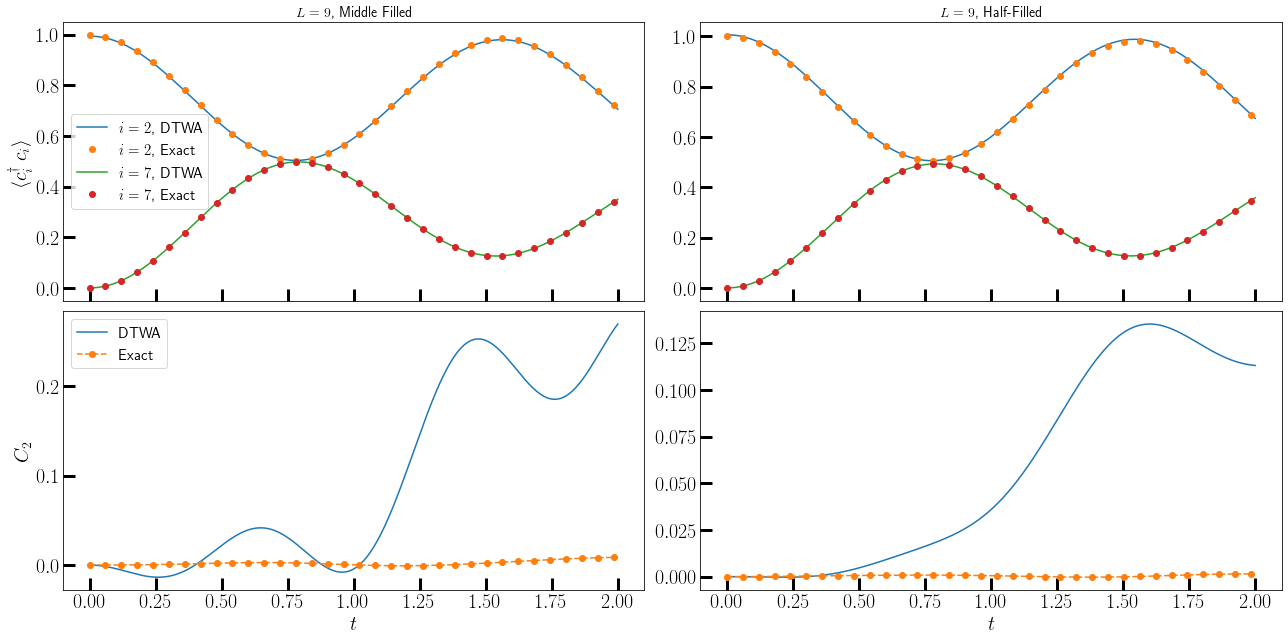

In [74]:
import numpy as np
from odeintw import odeintw
from multiprocessing import Pool

nsites = 9
xy = 2
middle_filled = np.arange(2,7)
half_filled = np.arange(0, nsites,2)

lsites = [2, 7] #sites where number density is to be plotted

params = {"lattice_size": nsites, "beta": 3.0, "occ_sites":None}

t = np.linspace(0, 2.0, 500)
niter = 2800
nprocs = 14

from scipy.sparse import dia_matrix
def get_smat(args):
    """
    This is the Dmn hopping matrix with power law decay.
    
    Parameters:
    args (dict): Dictionary containing parameters
                 1. "lattice_size" : Size of lattice
                 2. "beta"         : Long-range power law
                 
    Returns:
    numpy array : Long-Range antisymmetric hopping matrix
    """
    N = args["lattice_size"]
    J = dia_matrix((N, N))
    mid_diag = np.floor(N/2).astype(int)
    for i in np.arange(1,mid_diag+1):
        elem = pow(i, -args["beta"])
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    for i in np.arange(mid_diag+1, N):
        elem = pow(N-i, -args["beta"])
        J.setdiag(elem, k=i)
        J.setdiag(elem, k=-i)
    Jdense = J.toarray()
    #Anti-symmetric
    return np.triu(Jdense) - np.tril(Jdense)

#Plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
#Use latex labels
#rc('font',**{'family':'sans-serif','sans-serif':['Linux Libertine']})
rc('text', usetex=True)
#Size of fonts
fs = 20
rc({'axes.titlesize': fs})
rc({'axes.labelsize':fs})
rc({'figure.titlesize':fs})
rc({'legend.fontsize': 0.75 * fs})
#Size of figure
rc({'figure.figsize':(15,8)})
rc({'figure.autolayout':True})


if __name__ == '__main__':
    p = Pool(processes = nprocs)
    #Nearest neighbour kinetic energy
    J = np.diagflat(np.ones(nsites-1), k=1) + np.diagflat(np.ones(nsites-1), k=-1)
    #D = np.zeros((nsites, nsites))  #No interactions
    D = get_smat(params) #Long-range superconducting interactions
    V = None #No SYK
    
    fig, axs = plt.subplots(2, 2, sharex="col", figsize=(18,9))
    axs[0,0].set_ylabel(r"$\langle c^\dagger_i\;c_i\rangle$", fontsize=fs)
    axs[1,0].set_ylabel(r"$C_%d$" % xy, fontsize=fs)
    for _ in axs.flatten():
        _.tick_params(direction='in', length=12, width=3, labelsize=fs)
        
    niter_loc = int(niter/nprocs)
    for lsite in lsites:
        params["occ_sites"] = middle_filled
        out_all = p.starmap(evolve_dtwa_pos, [(s, t, lsite, xy if lsite == lsites[-1] else None, niter_loc, (J, D, None, params)) for s in np.arange(nprocs)])
        nsite_all = [_[0] for _ in out_all]
        axs[0,0].plot(t, np.average(nsite_all, axis=0).real, label=r"$i = %d$, DTWA" % lsite)
        nsite_exact, cxy_exact  = evolve_fermion_exact(t, lsite, xy if lsite == lsites[-1] else None, (J, D, None, params))
        axs[0,0].plot(t[::15], nsite_exact.real[::15],'o' ,label=r"$i = %d$, Exact" % lsite)
    axs[0,0].legend(fontsize=fs * 0.75, loc='best')    
    cxy_all = [_[1] for _ in out_all]
    axs[1,0].plot(t,np.average(cxy_all, axis=0).real, label='DTWA')
    axs[1,0].set_xlabel(r"$t$", fontsize=fs)
    axs[1,0].plot(t[::15], cxy_exact[::15].real, 'o--', label='Exact')
    axs[1,0].legend(fontsize=fs * 0.75, loc='best')   
    axs[0,0].set_title( r'$L=%d$, Middle Filled' % nsites, fontsize=0.7 * fs)
    
    for lsite in lsites:
        params["occ_sites"] = half_filled
        out_all = p.starmap(evolve_dtwa_pos, [(s, t, lsite, xy if lsite == lsites[-1] else None, niter_loc, (J, D, None, params)) for s in np.arange(nprocs)])
        nsite_all = [_[0] for _ in out_all]
        axs[0,1].plot(t, np.average(nsite_all, axis=0).real, label=r"$i = %d$, DTWA" % lsite)
        nsite_exact, cxy_exact  = evolve_fermion_exact(t, lsite, xy if lsite == lsites[-1] else None, (J, D, None, params))
        axs[0,1].plot(t[::15], nsite_exact.real[::15],'o' ,label=r"$i = %d$, Exact" % lsite)
    cxy_all = [_[1] for _ in out_all]
    axs[1,1].plot(t,np.average(cxy_all, axis=0).real, label='DTWA')
    axs[1,1].set_xlabel(r"$t$", fontsize=fs)
    axs[1,1].plot(t[::15], cxy_exact.real[::15],'o--', label='Exact')
    axs[0,1].set_title(r'$L=%d$, Half-Filled' % nsites, fontsize=0.7 * fs)    
    
    fig.tight_layout()
    plt.show()

## Truncated Wigner for Intraband Coulomb Scattering: 

Let us consider a model of $N$ fermions in a lattice where, $\Delta = 0$ and 

\begin{eqnarray}
J_{ij} &=& 2\cos{\left(\frac{2\pi i}{N-1}\right)}\;\delta_{ij}\\
V_{ijkl} &=& \begin{cases}
\frac{N-1}{4\pi|i-l|^2}\;\delta_{i+j,\;k+l} & i\neq l\\
0 & i=l
\end{cases}
\end{eqnarray}

Recall that, in a reciprocal lattice, momenta $k, k_1, k_2, k_3, k_4$ defined in the Brillouin zone $[0, 2\pi]$ have values $2\pi n/(N-1)$ with $n\in[0,N)$. Thus, the resultant Hamiltonian

\begin{equation}
H = -\sum_k 2\cos{\left(k\right)}\;c^\dagger_kc_k +\frac{1}{2}\sum_{\substack{k_1k_2k_3k_4\\k_1\neq k_4}}\left(\frac{\delta_{k_1+k_2,\;k_3+k_4}}{|k_1-k_4|^2}\right) c^\dagger_{k_1}c^\dagger_{k_2}c^\;_{k_3}c^\;_{k_4}
\end{equation}

When transformed to position space, this yields the Hamiltonian for $M$ charged particles, tightly bound in a single band in a periodic lattice, interacting via standard Coulomb repulsion.

Right off the bat we can see a huge problem with TWA. If we start from the Fermi sea of $M$ uncorrelated particles at $t=0$, then the $\tau$ matrices start at $0$ and the $\rho$ matrices start as diagonal, with the diagonal components corresponding to occupied momenta chosen randomly as per the topmost section of this writeup. The TWA dynamics, at t=0, yield

\begin{eqnarray}
\frac{\mathrm{d}}{\mathrm{d}t}\rho_{\alpha\beta}\bigg\rvert_{t=0} &=&
-2i  V_{i j k l} \delta_{\alpha l}\delta_{i k} \rho_{j \beta} + 2i  V^\ast_{i j k l} \delta_{\beta l}\delta_{i k} \rho^\ast_{j \alpha}\\
\frac{\mathrm{d}}{\mathrm{d}t}\tau_{\alpha\beta}\bigg\rvert_{t=0} &=& 0
\end{eqnarray}

Clearly, if $V_{ijkl}$ are real, then the average velocities of $\rho$ and $\tau$ vanish, yielding no dynamics. This is borne about by the simulation coded in the cell below.

NameError: name 'evolve_dtwa_pos' is not defined

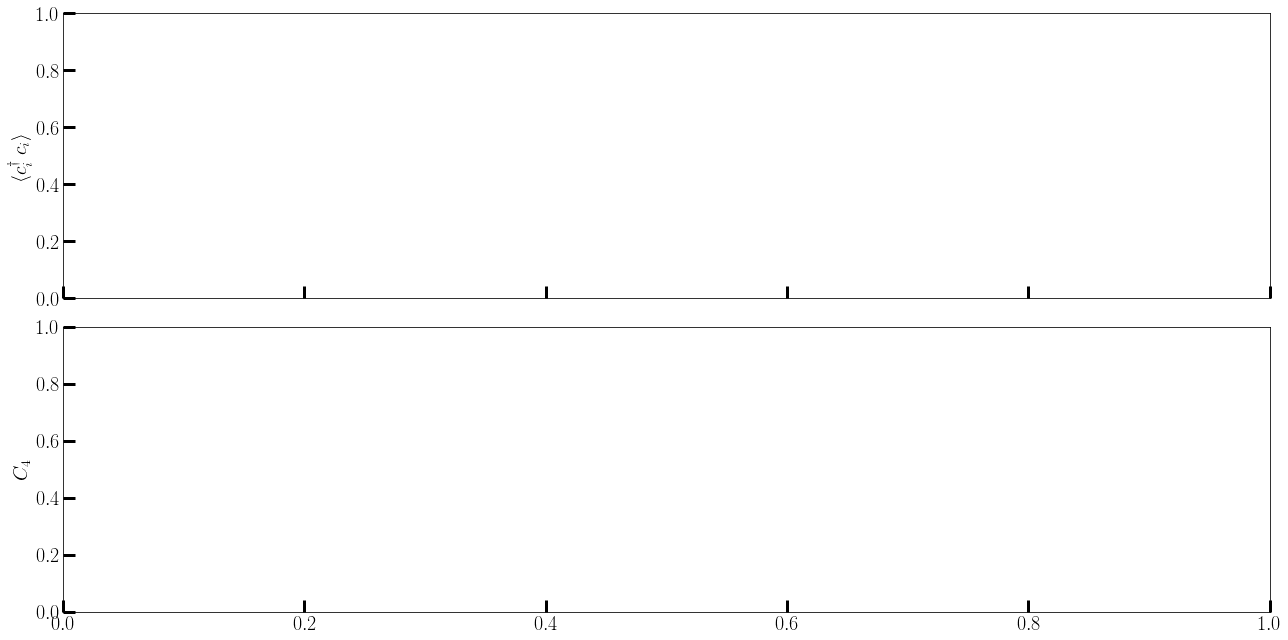

In [1]:
import numpy as np
from odeintw import odeintw
from multiprocessing import Pool

nsites = 5
xy = 4
middle_filled = [1,2]

lsites = [2, 4] #sites where number density is to be plotted

params = {"lattice_size": nsites, "occ_sites":middle_filled}

t = np.linspace(0, 4.0, 500)
niter = 1400
nprocs = 14

#Plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
#Use latex labels
#rc('font',**{'family':'sans-serif','sans-serif':['Linux Libertine']})
rc('text', usetex=True)
#Size of fonts
fs = 20
rc({'axes.titlesize': fs})
rc({'axes.labelsize':fs})
rc({'figure.titlesize':fs})
rc({'legend.fontsize': 0.75 * fs})
#Size of figure
rc({'figure.figsize':(15,8)})
rc({'figure.autolayout':True})


if __name__ == '__main__':
    p = Pool(processes = nprocs)
    J = np.diagflat(2.0 * np.cos(2.0 * np.pi * np.arange(nsites)/(nsites-1)))
    D = None
    V = np.zeros((nsites, nsites, nsites, nsites))
    k1, k2, k3, k4 = np.indices((nsites, nsites, nsites, nsites))    
    for i,j,k,l in np.vstack(np.where((k1+k2)==(k3+k4))).T:
        if i !=l:
            V[i,j,k,l] = (nsites-1)/(4.0 * np.pi) * 1./np.abs(i-l)**2

    
    fig, axs = plt.subplots(2, 1, sharex="col", figsize=(18,9))
    axs[0].set_ylabel(r"$\langle c^\dagger_i\;c_i\rangle$", fontsize=fs)
    axs[1].set_ylabel(r"$C_%d$" % xy, fontsize=fs)
    for _ in axs.flatten():
        _.tick_params(direction='in', length=12, width=3, labelsize=fs)
        
    niter_loc = int(niter/nprocs)
    for lsite in lsites:
        out_all = p.starmap(evolve_dtwa_pos, [(s, t, lsite, xy if lsite == lsites[-1] else None, niter_loc, (None, None, V, params)) for s in np.arange(nprocs)])
        nsite_all = [_[0] for _ in out_all]
        axs[0].plot(t, np.average(nsite_all, axis=0).real, label=r"$i = %d$, DTWA" % lsite)
        nsite_exact, cxy_exact  = evolve_fermion_exact(t, lsite, xy if lsite == lsites[-1] else None, (None, None, V, params))
        axs[0].plot(t[::15], nsite_exact.real[::15],'o--' ,label=r"$i = %d$, Exact" % lsite)
    axs[0].legend(fontsize=fs * 0.75, loc='best')    
    cxy_all = [_[1] for _ in out_all]
    axs[1].plot(t,np.average(cxy_all, axis=0).real, label='DTWA')
    axs[1].set_xlabel(r"$t$", fontsize=fs)
    axs[1].plot(t[::15], cxy_exact[::15].real, 'o--', label='Exact')
    axs[1].legend(fontsize=fs * 0.75, loc='best')   
    axs[0].set_title( r'$N=%d$, Half Filled' % nsites, fontsize=0.7 * fs)

## Truncated Wigner for Sachdev-Ye-Kitaev model in Coordinate Space
The code block below simulates the TWA dynamics of a lattice of spinless fermions in the SYK model. This is  compared with dynamics obtained from the exact dynamics of the Schrodinger equation using the openfermion package.  

In the SYK model, $J,D=0$, and the tensor $V = (2N)^{-3/2}J$, with $J$ being a rank$-4$ tensor of random Gaussian numbers with no mean and unit variance .

The simulation in the code cell below shows that agreement with exact diagonalization is very poor, at least for a single disorder realization. Presumably it will be better after averaging over multiple disorder realizations of $V_{ijkl}$. 

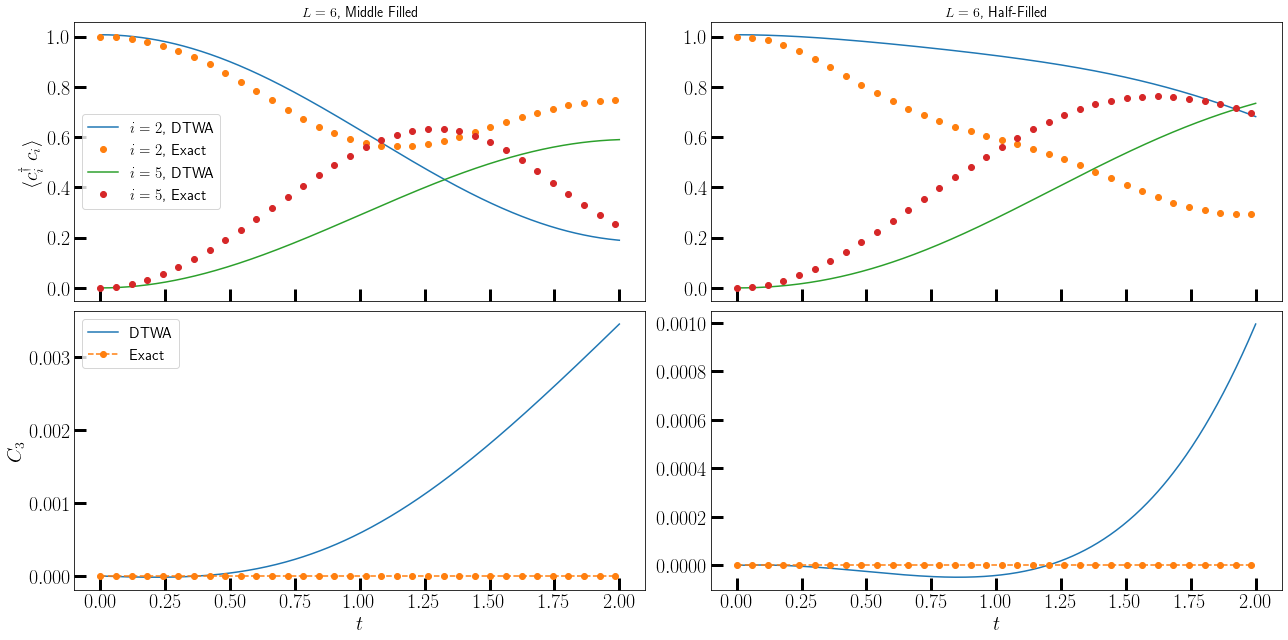

In [79]:
import numpy as np
from odeintw import odeintw
from multiprocessing import Process, Pool

nsites = 6
xy = 3
middle_filled = [1,2, 3]
half_filled = [0, 2, 4]

lsites = [2, 5] #sites where number density is to be plotted

params = {"lattice_size": nsites, "occ_sites":None}

t = np.linspace(0, 2.0, 500)
niter = 1400
nprocs_syk = 2
nprocs_pool = 7

#Plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
#Use latex labels
#rc('font',**{'family':'sans-serif','sans-serif':['Linux Libertine']})
rc('text', usetex=True)
#Size of fonts
fs = 20
rc({'axes.titlesize': fs})
rc({'axes.labelsize':fs})
rc({'figure.titlesize':fs})
rc({'legend.fontsize': 0.75 * fs})
#Size of figure
rc({'figure.figsize':(15,8)})
rc({'figure.autolayout':True})


if __name__ == '__main__':
    p = Pool(processes = nprocs)
    J, D = None, None
    V = (np.random.normal(0.0, 2.0, size=(nsites, nsites, nsites, nsites))/(2*nsites) +\
        (1j) * np.random.normal(0.0, 1.0, size=(nsites, nsites, nsites, nsites)))/(2*nsites)**(1.5)
    #Hermitianize it
    V = V - np.transpose(V,(0,1,3,2))
    V = V - np.transpose(V,(1,0,2,3))
    V = V + np.transpose(V,(2,3,0,1)).conjugate()
    
    fig, axs = plt.subplots(2, 2, sharex="col", figsize=(18,9))
    axs[0,0].set_ylabel(r"$\langle c^\dagger_i\;c_i\rangle$", fontsize=fs)
    axs[1,0].set_ylabel(r"$C_%d$" % xy, fontsize=fs)
    for _ in axs.flatten():
        _.tick_params(direction='in', length=12, width=3, labelsize=fs)
        
    niter_loc = int(niter/nprocs)
    for lsite in lsites:
        params["occ_sites"] = middle_filled
        out_all = p.starmap(evolve_dtwa_pos, [(s, t, lsite, xy if lsite == lsites[-1] else None, niter_loc, (None, None, V, params)) for s in np.arange(nprocs)])
        nsite_all = [_[0] for _ in out_all]
        axs[0,0].plot(t, np.average(nsite_all, axis=0).real, label=r"$i = %d$, DTWA" % lsite)
        nsite_exact, cxy_exact  = evolve_fermion_exact(t, lsite, xy if lsite == lsites[-1] else None, (None, None, V, params))
        axs[0,0].plot(t[::15], nsite_exact.real[::15],'o' ,label=r"$i = %d$, Exact" % lsite)
    axs[0,0].legend(fontsize=fs * 0.75, loc='best')    
    cxy_all = [_[1] for _ in out_all]
    axs[1,0].plot(t,np.average(cxy_all, axis=0).real, label='DTWA')
    axs[1,0].set_xlabel(r"$t$", fontsize=fs)
    axs[1,0].plot(t[::15], cxy_exact[::15].real, 'o--', label='Exact')
    axs[1,0].legend(fontsize=fs * 0.75, loc='best')   
    axs[0,0].set_title( r'$L=%d$, Middle Filled' % nsites, fontsize=0.7 * fs)
    
    for lsite in lsites:
        params["occ_sites"] = half_filled
        out_all = p.starmap(evolve_dtwa_pos, [(s, t, lsite, xy if lsite == lsites[-1] else None, niter_loc, (None, None, V, params)) for s in np.arange(nprocs)])
        nsite_all = [_[0] for _ in out_all]
        axs[0,1].plot(t, np.average(nsite_all, axis=0).real, label=r"$i = %d$, DTWA" % lsite)
        nsite_exact, cxy_exact  = evolve_fermion_exact(t, lsite, xy if lsite == lsites[-1] else None, (None, None, V, params))
        axs[0,1].plot(t[::15], nsite_exact.real[::15],'o' ,label=r"$i = %d$, Exact" % lsite)
    cxy_all = [_[1] for _ in out_all]
    axs[1,1].plot(t,np.average(cxy_all, axis=0).real, label='DTWA')
    axs[1,1].set_xlabel(r"$t$", fontsize=fs)
    axs[1,1].plot(t[::15], cxy_exact.real[::15],'o--', label='Exact')
    axs[0,1].set_title(r'$L=%d$, Half-Filled' % nsites, fontsize=0.7 * fs)    
    
    fig.tight_layout()
    plt.show()

# Appendix
## Truncated Wigner for Kitaev Chain in Momentum Space
In momentum space, the  number density can be calculated from the mapping

\begin{equation}
c^\dagger_qc_q \rightarrow \frac{1}{2} + \frac{1}{N}\rm{Tr}\left[D(q)\rho^T\right],
\end{equation}

where the dynamical matrix $D(q)$ has elements $D_{xy}(q) = e^{iq (x-y)}$. The average of this over random realizations is evaluated below.

## Exact Hamiltonian Dynamics in Single Particle Basis

The exact dynamics is obtained as follows. The Hamiltonian is 

\begin{eqnarray}
H &=& -\frac{1}{2}\sum_{ij}J_{ij}\left(c^\dagger_i c^\;_j + c^\dagger_j c^\;_i\right) + \frac{1}{2}\sum_{ij} \left(\Delta_{ij}c^\;_ic^\;_j + \Delta^\dagger_{ij} c^\dagger_jc^\dagger_i\right)\nonumber \\
&=& \frac{1}{2}\begin{pmatrix} C^\dagger & C \end{pmatrix}\;\begin{pmatrix}J & \Delta \\ \Delta^\dagger & -J\end{pmatrix}\begin{pmatrix} C \\ C^\dagger \end{pmatrix}
\end{eqnarray}.

Here, $C(t) = \left(c_0(t), c_1(t), c_2(t) \dots c_{N-1}(t)\right)$ in the Heisenberg picture. We now define fermionic operators $\Gamma = \left(\gamma_0, \gamma_1, \gamma_2 \dots \gamma_{N-1}\right)$ such that 

\begin{equation}
\gamma_\nu = \begin{cases}
c^\dagger_\nu & \nu\in\mathcal{M}\\
0 & \mbox{otherwise.}
\end{cases}
\end{equation}

Finally, defining the unitary transformation

\begin{equation}
\begin{pmatrix}C \\ C^\dagger\end{pmatrix} = \begin{pmatrix}U & V^\ast \\ V & U^\ast\end{pmatrix} \begin{pmatrix}\Gamma \\ \Gamma^\dagger\end{pmatrix},
\end{equation}

substituting them into the Heisenberg equations and comparing components of
$\Gamma, \Gamma^\dagger$ yields the dynamical equations for the matrices $U$ and $V$

\begin{equation}
i \frac{\mathrm d}{\mathrm{d}t}\begin{pmatrix}U \\ V\end{pmatrix} =  \begin{pmatrix}J & \Delta \\ -\Delta & -J^K\end{pmatrix}\begin{pmatrix}U \\ V\end{pmatrix}
\end{equation}

The initial conditions are obtained as follows. If $|\Psi\rangle$ only has sites in
$\mathcal{M}$ occupied, then $U=0$ and

\begin{equation}
V_{ij} = \begin{cases}
\delta_{ij} & j\in\mathcal{M}\\
0 & \mbox{ otherwise }.
\end{cases}
\end{equation}

The required observables can be readily obtained in this representation by using the
definitions in the previous section and applying Wick's theorem. This yields

\begin{equation}
n_i = \langle \Psi|c^\dagger_i(t)c^\;_i(t)|\Psi\rangle = \left(VV^\dagger\right)_{ii},
\end{equation}

and

\begin{multline}
C(x,y) =\\
\frac{1}{N^2}\sum_{x'y'}\langle \Psi| c^\dagger_{x+x'}c^\dagger_{x'}c_{y'}c_{y+y'}|\Psi \rangle
=\frac{1}{N^2}\bigg[\rm{Tr}\left(VV^\dagger\right)_{x0}
\big\{\rm{Tr}\left(UU^\dagger\right)_{0y}
 - \rm{Tr}\left(UU^\dagger\right)_{y0} \big\} \\
+ \rm{Tr}\big\{\left(VU^\dagger\right)_{xy}\left(UV^\dagger\right)^T\big\}\bigg].
\end{multline}

Here, $A_{kl}$ is the matrix obtaining by rolling the zeroth axis by $k$ places and first axis (columns) by $l$ places. The above-mentioned result was obtained using Wick contractions. **CHECK THIS**

The code for executing this algorithm is given below.